# Probabilistic Principal Component Analysis (PPCA)

~~~
Extracción de Características en Imágenes.
Máster en Ciencia de Datos e Ingeniería de Computadores.
Universidad de Granada.

Francisco Javier Sáez Maldonado - fjaviersaezm@ugr.es
Rafael Molina Soriano - rms@decsai.ugr.es

Créditos: Francisco Miguel Castro Macías, Fernando Pérez Bueno
~~~

En este guión, vamos a estudiar la versión probabilistica del análisis de componentes principales. Esto nos va a permitir, por un lado, mirar al modelo PCA que hemos estudiado desde otro punto de vista (modelo generativo) y, por otro, dar el primer paso hacia los Variational AutoEncoders (VAEs) y Generative Adversarial Networks (GANs).

Vamos a trabajar con el mismo dataset de caras de la práctica de PCA. Veremos qué ocurre cuando tenemos que aprender el modelo con datos ruidosos.

Como hemos visto en teoría, PPCA también utiliza los autovalores y autovectores, por lo que tendrás que reutilizar parte del código de la práctica anterior.

PPCA responde al siguiente modelo probabilístico (tomamos los datos normalizados):

\begin{align*}
p(\mathbf{z}) &= \mathcal{N}(\mathbf{z} \mid \mathbf{0}, \mathbf{I})\\
p(\mathbf{x} \mid \mathbf{z}) &= \mathcal{N}(\mathbf{x} \mid \mathbf{W} \mathbf{z},\sigma^2 \mathbf{I})\
\end{align*}

La intuición detrás de este modelo es como sigue:

1. Para cada observación $\mathbf{x}$ tenemos una variable latente 'implícita' (que no observamos) $\mathbf{z}$ con $M$ componentes ($M$ es el número de componentes principales escogido). Introducimos una distribución a priori (gaussiana) $p(\mathbf{z})$ sobre la variable latente. De ella extraemos una muestra $\mathbf{z}$.
2. Con esa muestra generamos nuestras observaciones usando el modelo de observación $p(\mathbf{x} \mid \mathbf{z})$ (en nuestro caso lineal y con ruido Gaussiano).

Para que te situes: en la clase de teoría sobre PPCA hemos supuesto que tenemos $N$ ejemplos, cada uno con $D$ componentes. Usaremos $M$ para notar el número de componentes principales. Observa que $\mathbf{W}$ tiene tamaño $D \times M$ y $\sigma^2$ controla la varianza de la distribución condicionada (cuánto ruido tenemos en las observaciones).

Librerias que vamos a utilizar en el desarrollo de la práctica.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

Lectura de los datos. Recuerda modificar la ruta para cargar tu fichero. 

In [ ]:
path = "./"

dict_data = loadmat(path + "ERRDfaces_2021.mat")
data = dict_data["X"]

print(
    f"Tenemos N={data.shape[0]} muestras, cada una con D={data.shape[1]} componentes."
)


Tenemos N=5000 muestras, cada una con D=1024 componentes.


# Añadiendo ruido a los datos

A continuación vamos a añadir ruido gaussiano a cada una de las componentes de las instancias de nuestro problema. Luego haremos la partición en train y test.

Inicializamos el generador de números aleatorios para que en todas las ejecucuones generemos los mismos datos de ruido. 

A continuación fijamos la varianza del ruido a 10. Observa el rango en el que se encuentran nuestros datos antes de aplicarles el ruido. Piensa en el efecto de añadirle ruido de varianza 10. Piensa el rango en el que el ruido está en el 95% de los casos. 

In [ ]:
# Información sobre los datos

print(f"Rango de los datos originales: [{data.min():.2f}, {data.max():.2f}]")

# Inicializamos la semilla del ruido y le añadimos ruido a los datos

np.random.seed(42)

var_ruido = 10
ruido = np.random.normal(0, np.sqrt(var_ruido), data.shape)

data_noisy = data + ruido

print(f"Rango de los datos ruidosos: [{data_noisy.min():.2f}, {data_noisy.max():.2f}]")

Rango de los datos originales: [-127.87, 127.50]
Rango de los datos ruidosos: [-138.17, 137.03]


Como hiciste en la práctica anterior, debemos redimensionar los datos para mostrar las imágenes. Pasamos de un vector con 1024 componentes a una matriz 32x32, y mostramos las 5 primeras caras del dataset sin ruido en la primera fila y con ruido en la segunda fila.

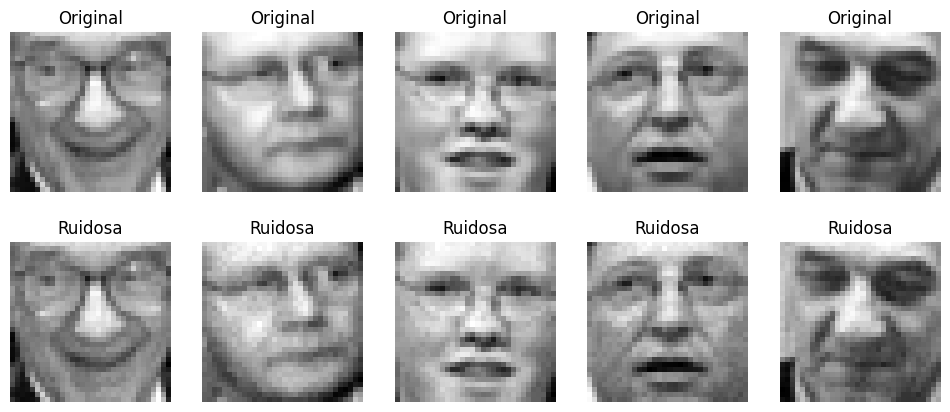

In [ ]:
n_caras = 5
plt.figure(figsize=(12, 5))
for i in range(n_caras):
    plt.subplot(2, n_caras, i + 1)
    I = np.reshape(data[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("Original")
    plt.axis("off")  # quita esta orden para ver número de filas y columna

    plt.subplot(2, n_caras, i + n_caras + 1)
    I = np.reshape(data_noisy[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("Ruidosa")
    plt.axis("off")  # quita esta orden para ver número de filas y columnas
plt.show()

Como en la práctica anterior, usaremos las 4500 primeras caras como ejemplos de entrenamiento y las restantes 500 como test. De esta forma podremos comparar con los resultados obtenidos en la práctica anterior. 

In [5]:
N_tr = 4500
X_noisy = data_noisy[0:N_tr, :]
test_noisy = data_noisy[N_tr:, :]

# Normalización de los datos

Igual que en el caso de PCA, normalizaremos los datos. Recuerda que en esta ocasión, nuestros datos a normalizar son `X_noisy`.

> 📝 **Pregunta 1.** Usando la clase `StandardScaler` de sklearn normaliza los datos de entrenamiento, de forma que cada rasgo (de los 1024) tenga media cero. No realices el escalado de la varianza a uno. Los rasgos normalizados deberás almacenarlos en la variable `X_norm`. Ten en cuenta que más tarde tendrás que aplicar la misma normalización a los datos de test.

In [6]:
from sklearn.preprocessing import StandardScaler

# Introduce aquí tu código para normalizar los datos. Introduce los datos normalizados en una variable de nombre X_norm
scaler = StandardScaler(with_std=False)
scaler.fit(X_noisy)
X_norm = scaler.transform(X_noisy)

# Cálculo de las PCAs 

Una vez que hemos normalizado los datos vamos a calcular todos los vectores y matrices que usa PPCA. 

Aunque existe una función implementada en el paquete sklearn nosotros no la utilizaremos para comprender en profundidad el funcionamiento de PPCA. No se considera válido para el desarrollo de la práctica el uso de implementaciones existentes de PPCA.

> 📝 **Pregunta 2.** Utiliza la descomposición por valores sigulares de `X_norm` o `X_norm` traspuesta usando la función `np.linalg.svd()` y de ahí obtén los autovectores de la matriz de covarianza muestral y sus valores singulares. Con estos valores singulares puedes calcular los autovalores de la matriz de covarianza muestral como ya hiciste en la práctica de PCA. No te confundas, los valores singulares de `X_norm` o `X_norm` transpuesta no son los autovalores de la matriz de covarianza muestral. Alternativamente, puedes calcular los autovectores y autovalores de la matriz de covarianza muestral  utilizando la función `np.linalg.eig()`.

In [7]:
U, D, V = np.linalg.svd(X_norm, full_matrices=False)
eigen_vectors = V
eigen_values = (D**2) / X_norm.shape[0]

# Obtenemos los índices ordenados
indexes = np.argsort(eigen_values)[::-1]

# Introduce en autovalores los autovalores (ordenados) de la matriz de covarianza muestral
autovalores = eigen_values[indexes]

# Introduce en autovectores los vectores (ordenados) que definen la transformación de PCA
autovectores = eigen_vectors[:, indexes].T

## Cálculo de los estimadores de máxima verosimilitud en PPCA

Calculados los autovectores y autovalores de la matriz de covarianza muestral, podemos calcular la matriz $\mathbf{W}$ cuyas columnas generan el subespacio principal. Como sabemos, su estimador de máxima verosimilitud (max-likelihood) es:

\begin{equation*}
\mathbf{W}_{\mathrm{ML}} = \mathbf{U}(\mathbf{L}-\sigma^2 \mathbf{I})^{1/2} \mathbf{R} \\
\end{equation*}

donde $\mathbf{U}$ es una matriz $D \times M$ cuyas columnas corresponden a los $M$ autovectores o autocaras asociadas a los $M$ mayores autovalores de la matriz de covarianza muestral, $\mathbf{L}$ es una matriz diagonal que contiene los autovalores correspondientes y $\mathbf{R}$ es una matriz ortonormal de dimensiones $M \times M$ (una matriz de rotación arbitraria). Por simplicidad, supondremos que $\mathbf{R}$ es la matriz identidad.

Como estimador de $\sigma^2$ usaremos su estimador de máxima verosimilitud que como sabes es

\begin{equation*}
\sigma_{\mathrm{ML}}^2 = \frac{1}{D-M}\sum_{i=M+1}^D\lambda_i \\
\end{equation*}

Igual que hicimos en la práctica anterior, vamos a utilizar 250 autocaras ($M=250$), es decir, `n_componentes=250`.

> 📝 **Pregunta 3.** Calcula $\sigma^2_{ML}$ y muestra su valor.

In [8]:
# Número de vectores que generarán el subespacio (P)
n_componentes = 250

# Dimensión de las instancias (M)
Dimension_datos = data.shape[1]

sigma2_ml = np.sum(autovalores[n_componentes:]) / (Dimension_datos - n_componentes)
print(sigma2_ml)

47.89553254484908


> 📝 **Pregunta 4** ¿Cómo se relaciona $\sigma_{\mathrm{ML}}^2$ (el estimador de máxima verosimilitud de la varianza del ruido) con la varianza del ruido introducido cuando todavía no habías normalizado los datos?

> **Respuesta**: 
Antes de normalizar, el ruido introducido a los datos afecta directamente a los autovalores de la matriz de covarianza, ya que incrementa la variabilidad en todas las direcciones del espacio de características. Con $\sigma^2_{ml}$ se captura la varianza del ruido añadido a los datos antes de la normalización, ya que los autovalores pequeños (desde $M+1$ a $D$) capturan esta variabilidad residual.

> 📝 **Pregunta 5.** Obten $\mathbf{U}$ de `autovectores` y la matriz $\mathbf{L}$. En la expresión de $\mathbf{W}_{\mathrm{ML}}$ fija $\sigma^2 = \sigma^2_{ML}$ y calcula $\mathbf{W}_{\mathrm{ML}}$ en la variable `W_ml`. Se han incluido algunos cálculos para guiarte en el proceso.

In [9]:
U = autovectores[:, :n_componentes]
L = np.diag(autovalores[:n_componentes])

W_ml = U.dot((L - sigma2_ml * np.identity(n_componentes)) ** (1 / 2))

## Cálculo de $p( \mathbf{z} \mid \mathbf{x})$

Al utilizar PCA, teniamos un único valor de $\mathbf{z}$ para cada muestra $\mathbf{x}$. En PPCA tenemos una distribución dada por

\begin{equation*}
p( \mathbf{z} \mid \mathbf{x}) = {\mathcal{N}}( \mathbf{z} \mid \mathbf{M}^{-1} \mathbf{W}^\top \mathbf{x},\sigma^2 \mathbf{M}^{-1}),
\end{equation*}

donde $\mathbf{M}= \mathbf{W}^\top \mathbf{W}+\sigma^2\mathbf{I}$. Fíjate que aunque la matriz de covarianza es común a todas las muestras, la media varía para cada una de ellas.

> 📝 **Pregunta 6.** Usando los estimadores de máxima verosimilitud que ya hemos calculado, calcula $\mathbf{M}$, la media y la matriz de covarianzas de $\mathbf{z}$ para todos los datos de `X_norm`. Almacena todas las medias en `mean_Z` y la matriz de covarianza común en `covar_z`. Antes de hacer la implementación, piensa si puedes simplificar el cálculo de alguna de las matrices (concretamente, de la matrix $\mathbf{M}$). Observa que la dimensión de `mean_Z` es $250 \times 4500$ ya que contiene la media de esta distribución condicionada por columnas para cada una de las muestras de entrenamiento. Por ello hemos usado `mean_Z` en lugar de `mean_z`. La matriz de covarianza `covar_z` es la misma para todas las muestras y tiene dimensión $250 \times 250$.

In [10]:
M = W_ml.T.dot(W_ml) + sigma2_ml * np.identity(n_componentes)

mean_Z = np.linalg.inv(M).dot(W_ml.T).dot(X_norm.T)

covar_z = sigma2_ml * np.linalg.inv(M)

print("mean_Z", mean_Z.shape)
print("covar_z", covar_z.shape)

mean_Z (250, 4500)
covar_z (250, 250)


Vamos a dibujar la matriz de covarianza de $p(\mathbf{z} \mid \mathbf{x})$

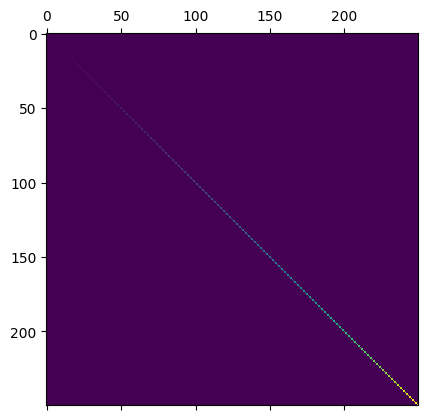

In [11]:
plt.matshow(covar_z)
plt.show()

> 📝 **Pregunta 7.** ¿Por qué tiene esa forma?

> **Respuesta**: 
La estructura de $covar_z$​ puede mostrarse como una matriz con valores más grandes en la diagonal (por la contribución de $\sigma^2$) y valores más pequeños en los elementos fuera de la diagonal (por las correlaciones entre las direcciones principales). Esto refleja cómo las dimensiones latentes están correlacionadas entre sí, pero la presencia de ruido isotrópico limita la intensidad de estas correlaciones. 
Las primeros componentes principales están asociados con los mayores autovalores de la matriz de covarianza, lo que significa que explican la mayor parte de la varianza de los datos.

## Sobre $p( \mathbf{x} \mid \mathbf{z})$ y su cálculo

Como sabes

\begin{equation*}
p( \mathbf{x} \mid \mathbf{z}) = \mathcal{N}(\mathbf{x} \mid \mathbf{W} \mathbf{z},\sigma^2 \mathbf{I}).
\end{equation*}

Nuevamente, la media depende de $\mathbf{z}$ mientras que la matriz de covarianza es constante. Una vez hemos fijado el valor de $\mathbf{z}$, esta distribución la podemos calcular muy fácilmente.

> 📝 **Pregunta 8.** Fijando $\mathbf{z}$ a las medias que hay en `mean_Z` y tomando los estimadores de máxima verosimilitud, calcula la media y la matriz de covarianza de cada una de las distribuciones $p( \mathbf{x} \mid \mathbf{z})$. Las llamaremos `mean_cond_X` y `covar_cond_x`, respectivamente. Es importante que esté claro para ti cuales son sus dimensiones.

In [12]:
mean_cond_X = W_ml.dot(mean_Z)

covar_cond_x = sigma2_ml * np.identity(X_norm.shape[1])

print("mean_cond_X", mean_cond_X.shape)
print("covar_cond_x", covar_cond_x.shape)

mean_cond_X (1024, 4500)
covar_cond_x (1024, 1024)


## Trabajando con $p( \mathbf{x} \mid \mathbf{z})$ y $p( \mathbf{z} \mid \mathbf{x})$ y comparando con PCA

Ya que tenemos todos los ingredientes podemos empezar a utilizar las distribuciones que hemos calculado. 

> 📝 **Pregunta 9.** A partir de `X_norm` hemos calculado `mean_Z` y `cov_z`, es decir, la media y la matriz de covarianza de $p( \mathbf{z} \mid \mathbf{x})$. 
> 1. Calcula las reconstrucciones por PPCA usando la media de $p( \mathbf{x} \mid \mathbf{z})$ para todos los ejemplos del conjunto de entrenamiento (es decir, fijando $\mathbf{z}$ a `mean_Z`), almacénalas en `X_rec`. 
> 2. Calcula también las reconstrucciones por PCA. Almacénalas en `X_rec_pca`.
> 3. Crea una figura con 4 filas y 5 columnas. Muestra las 5 primeras caras ruidosas de la base de datos original (primera fila), sus reconstrucciones con PPCA (segunda fila), y sus reconstrucción con PCA (tercera fila). En la cuarta fila debes mostrar las imágenes originales. 

No olvides deshacer la transformación de normalización en cada caso. Observa que estamos llevando las imagenes ruidosas observadas a un espacio latente y luego de nuevo al espacio original.

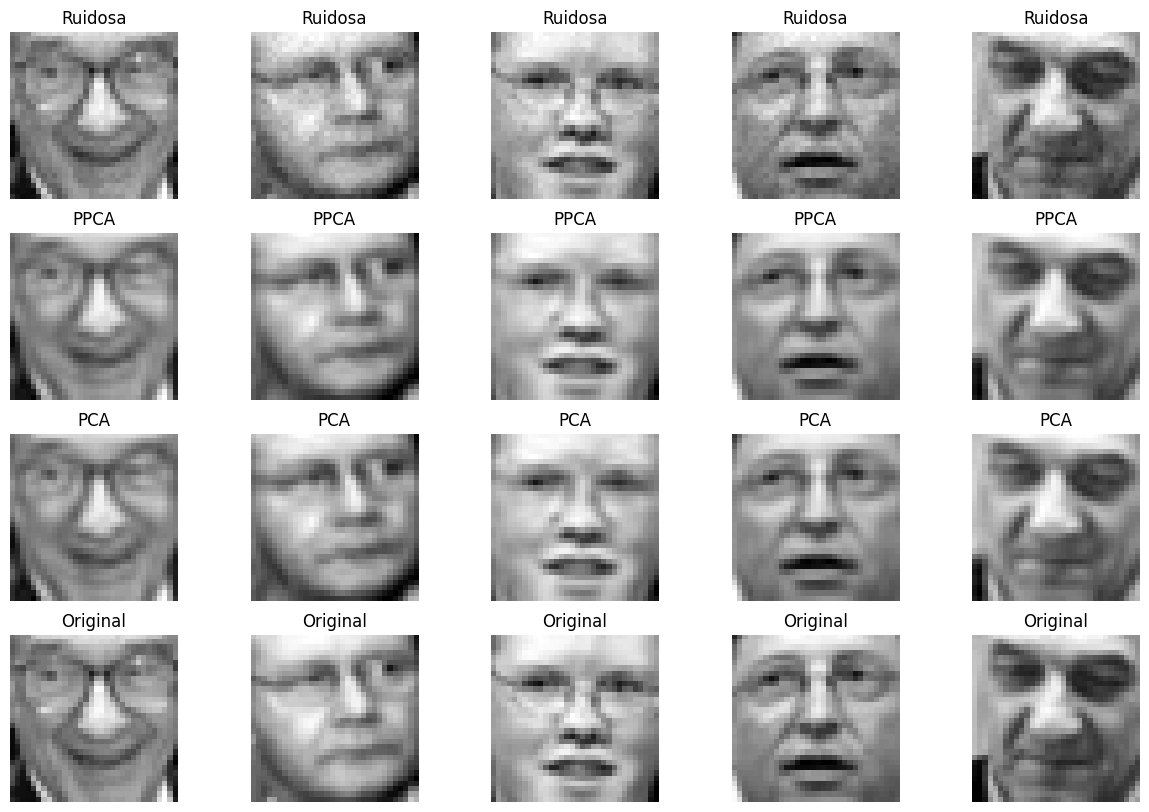

In [13]:
# Para PPCA
X_rec = scaler.inverse_transform(W_ml.dot(mean_Z).T)

# Para PCA
W = autovectores[:, :n_componentes]
Z = W.T.dot(X_norm.T)

X_rec_pca = scaler.inverse_transform(W.dot(Z).T)

n_caras = 5
n_row = 4
plt.figure(figsize=(15, 10))
for i in range(n_caras):
    plt.subplot(n_row, n_caras, i + 1)
    I = np.reshape(X_noisy[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("Ruidosa")
    plt.axis("off")

    plt.subplot(n_row, n_caras, i + 1 * n_caras + 1)
    I = np.reshape(X_rec[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("PPCA")
    plt.axis("off")

    plt.subplot(n_row, n_caras, i + 2 * n_caras + 1)
    I = np.reshape(X_rec_pca[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("PCA")
    plt.axis("off")

    plt.subplot(n_row, n_caras, i + 3 * n_caras + 1)
    I = np.reshape(data[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("Original")
    plt.axis("off")
plt.show()

Podría pensarse que la reconstrucción de las caras original es mejor con PCA que con PPCA. Piensa sobre qué modelo generalizará mejor a caras no vistas.

## Usando $p( \mathbf{x} \mid \mathbf{z})$ para obtener distintas muestras

Antes hemos mostrado la media de la distribución $p( \mathbf{x} \mid \mathbf{z})$, pero ahora probaremos a muestrearla.

> 📝 **Pregunta 10.** Has calculado antes `mean_cond_X` y `covar_cond_x`. Utiliza la clase `multivariate_normal` de `numpy.random` para generar 5 muestras de la primera cara del dataset y almacénalas en `X_muestras_1`. Luego debes deshacer la transformación incial y almacenar las muestras en `X_muestras_rec_1`. Muestra las 5 imagenes que obtienes.

Piensa qué pasaría si quisieras hacer lo mismo con PCAs.

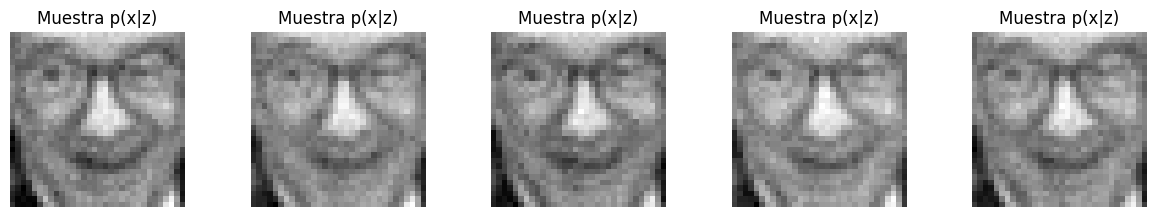

In [14]:
np.random.seed(42)

X_muestras_1 = np.random.multivariate_normal(mean_cond_X.T[0], covar_cond_x, 5)
X_muestras_rec_1 = scaler.inverse_transform(X_muestras_1)

plt.figure(figsize=(15, 5))
for i in range(n_caras):
    plt.subplot(2, n_caras, i + 1)
    I = np.reshape(X_muestras_rec_1[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("Muestra p(x|z)")
    plt.axis("off")
plt.show()

## Modelo generativo

Disponer de la distribución a priori $p(\mathbf{z})={\mathcal{N}}(\mathbf{0},\mathbf{I})$ nos permite generar nuevas caras.

> 📝 **Pregunta 11.** Utiliza la clase `normal` de `np.random` para generar 5 muestras de $p(\mathbf{z})$, a las que llamarás `Z_gen`. Para cada una de ellas muestra la media de $p( \mathbf{x} \mid \mathbf{z})$ y almacénalas todas en `X_gen`. Luego reconstruye (deshaz la transformación) y muéstralas.

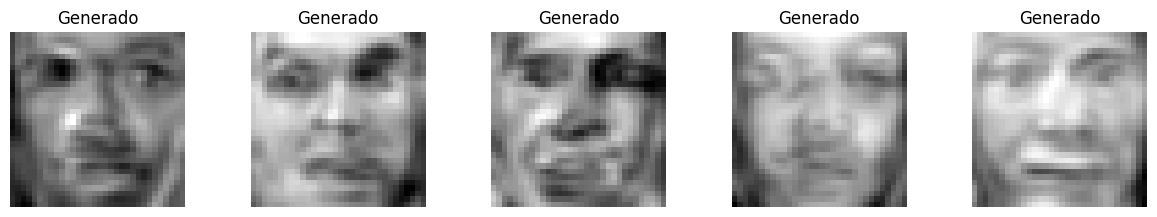

In [15]:
np.random.seed(42)

Z_gen = np.random.normal(0, 1, [n_componentes, 5])

# Proyección al espacio observado
X_gen = Z_gen.T.dot(W_ml.T)  # W_ml: matriz de pesos, mu: media original
X_gen_rec = scaler.inverse_transform(X_gen)  # Deshacer normalización, si aplica

n_caras = 5
plt.figure(figsize=(15, 5))
for i in range(n_caras):
    plt.subplot(2, n_caras, i + 1)
    I = np.reshape(X_gen_rec[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("Generado")
    plt.axis("off")
plt.show()

# Distribución marginal $p(\mathbf{x})$

Integrando la distribución conjunta $p(\mathbf{x},\mathbf{z})$ en $\mathbf{z}$ podemos obtener la distribución marginal $p(\mathbf{x})$.

\begin{equation*}
    p(\mathbf{x})=\int_{\mathbb{R}^M} p(\mathbf{x} \mid \mathbf{z})p(\mathbf{z}) \mathrm{d}\mathbf{z}=\mathcal{N}(\mathbf{x} \mid \mathbf{0}, \mathbf{C}),
\end{equation*}

donde $\mathbf{C} = \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}$.

> 📝 **Pregunta 12.** Calcula la matriz $\mathbf{C}$, su determinante y su inversa. Observa que podemos realizar estos cálculos porque el número de rasgos es pequeño. Si tuviésemos menos instancias que rasgos sería mejor usar la identidad de Woodbury y si ambos son muy grandes tendríamos un problema (que es posible solucionar).

/home/migue8gl/Master/extraccion_de_caracteristicas_en_imagenes/p3_ppca/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


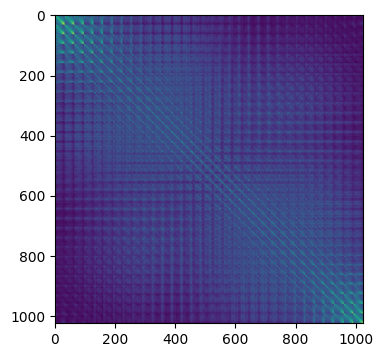

In [ ]:
C = W_ml.dot(W_ml.T) + sigma2_ml * np.identity(X_norm.shape[1])
det_C = np.linalg.det(C)
C_inv = np.linalg.inv(C)

plt.figure(figsize=(4, 4))
plt.imshow(C)
plt.show()

> 📝 **Pregunta 13.** Utiliza la clase `multivariate_normal` de `np.random` para generar 5 muestras de la distribución marginal $p(\mathbf{x})$ y almacénalas en `X_muestras`. No te confundas, no estás generando necesariamente caras similares a las que has aprendido porque no estás observando una $\mathbf{x}$ para generar una $\mathbf{z}$, y a partir de $\mathbf{z}$ recuperar $\mathbf{x}$.
    
Muestra las 5 imagenes que obtienes. No olvides, como siempre, deshacer la normalización. Las caras sin la normalización debes almacenarlas en `X_muestras_rec`.

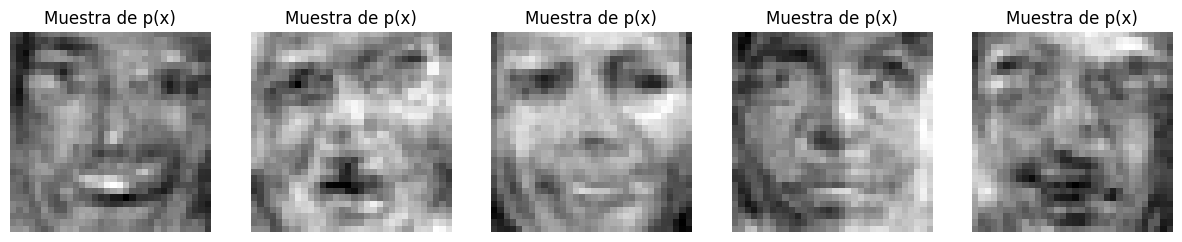

In [17]:
np.random.seed(42)

mean = np.mean(X_norm, axis=0)
cov = np.cov(X_norm.T)

X_muestras = np.random.multivariate_normal(mean, cov, 5)
X_muestras_rec = scaler.inverse_transform(X_muestras)

n_caras = 5
plt.figure(figsize=(15, 15))
for i in range(n_caras):
    plt.subplot(2, n_caras, i + 1)
    I = np.reshape(X_muestras_rec[i, :], [32, 32]).T
    plt.imshow(I, cmap="gray")
    plt.title("Muestra de p(x)")
    plt.axis("off")

# Detección de anomalías mediante $ \log p(\mathbf{x})$ 

Estimados $\mathbf{W}_{\mathrm{ML}}$ y $\sigma^2_{\mathrm{ML}}$ podemos calcular el logaritmo de la probabilidad de una observación $\mathbf{x}$:

\begin{equation*}
\log p(\mathbf{x} \mid \mathbf{W}_{\mathrm{ML}}, \sigma_{\mathrm{ML}}^2)=-\frac{M}{2}\log(2\pi)-\frac{1}{2}\log|\mathbf{C}|-\frac{1}{2}\color{red}{\mathbf{x}^\top \mathbf{C}^{-1} \mathbf{x}} 
\end{equation*} 

Esta cantidad se llama en inglés *log likelihood* y mide la verosimilitud de una muestra. Observa que $\log p(\mathbf{x} \mid \mathbf{W}_{\mathrm{ML}}, \sigma_{\mathrm{ML}}^2)$ es menor conforme menos probable sea la muestra $\mathbf{x}$. Puede usarse para identificar anomalías con respecto a las imágenes que hemos utilizado para aprender nuestro modelo. Observa que todos los términos de la derecha de la ecuación anterior son independientes de $\mathbf{x}$ salvo el que esta en rojo, por lo que este es el único que nos importa. 

> 📝 **Pregunta 14.** Calcula $\mathbf{x}^\top \mathbf{C}^{-1} \mathbf{x}$ para cada muestra $\mathbf{x}$ en `X_norm` y almacenalo en `X_error`. Este último será un vector con tantas componentes como datos en el conjunto de entrenamiento (es decir, 4500).

In [18]:
X_error = np.linalg.diagonal(X_norm.dot(C_inv).dot(X_norm.T))

Usando los errores que has calculado vamos a mostrar la cara que tiene mayor probabilidad.

Índice de la cara más probable: 647


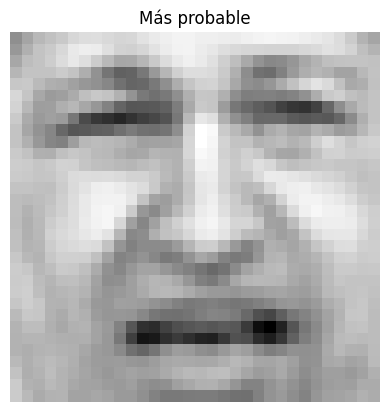

In [19]:
index_min_error = np.argmin(X_error)
print("Índice de la cara más probable: {}".format(1 + index_min_error))
I = np.reshape(X_rec[index_min_error, :], [32, 32]).T
plt.imshow(I, cmap="gray")
plt.title("Más probable")
plt.axis("off")
plt.show()

Usando los errores que has calculado vamos a mostrar la cara que tiene menor probabilidad.

Índice de la cara menos probable: 3088


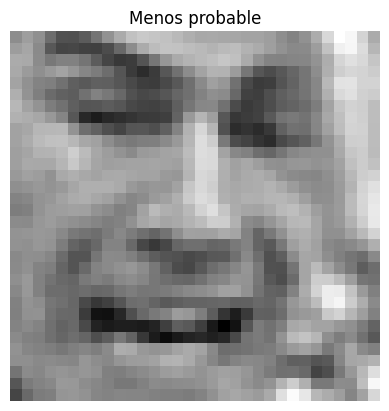

In [ ]:
index_max_error = np.argmax(X_error)
print("Índice de la cara menos probable: {}".format(1 + index_max_error))
I = np.reshape(X_rec[index_max_error, :], [32, 32]).T
plt.imshow(I, cmap="gray")
plt.title("Menos probable")
plt.axis("off")
plt.show()

# Detección de anomalías en test

Para terminar este guión vamos a ver cómo de probables son nuestros datos de test.

> 📝 **Pregunta 15.** Usando el modelo que hemos construido, encuentra la muestra de test que es más probable y la menos probable.

Índice de la cara más probable: 303


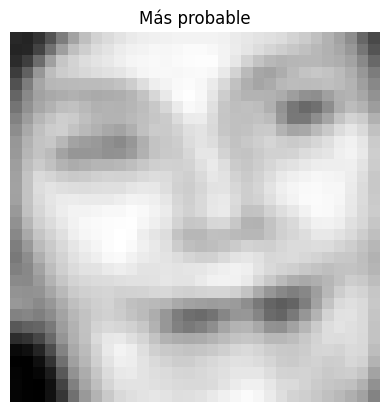

Índice de la cara menos probable: 286


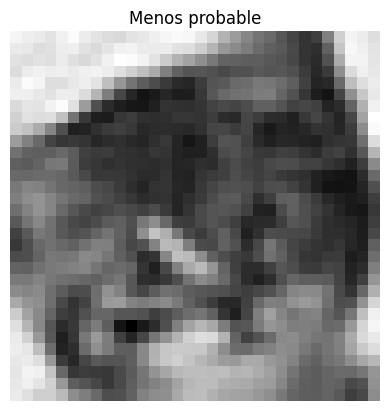

In [21]:
X_test_norm = scaler.transform(test_noisy)

mean_test_Z = np.linalg.inv(M).dot(W_ml.T).dot(X_test_norm.T)

X_error_test = np.linalg.diagonal(X_test_norm.dot(C_inv).dot(X_test_norm.T))
X_test_rec = scaler.inverse_transform(W_ml.dot(mean_test_Z).T)

index_min_error = np.argmin(X_error_test)
print("Índice de la cara más probable: {}".format(1 + index_min_error))
I = np.reshape(X_test_rec[index_min_error, :], [32, 32]).T
plt.imshow(I, cmap="gray")
plt.title("Más probable")
plt.axis("off")
plt.show()

index_max_error = np.argmax(X_error_test)
print("Índice de la cara menos probable: {}".format(1 + index_max_error))
I = np.reshape(X_test_rec[index_max_error, :], [32, 32]).T
plt.imshow(I, cmap="gray")
plt.title("Menos probable")
plt.axis("off")
plt.show()


# Para terminar

> 📝 **OPCIONAL.** Nos hemos dejado muchas cosas interesantes por hacer. Te sugiero que pienses en las siguientes y escribas el código que te permita analizar lo que está pasando. Si quieres inclúyelo aquí.
> 1. ¿Qué diferencias habrá entre el espacio latente de PCA y de PPCA? Sí, el PCA es determinista pero, ¿cuáles serán las implicaciones de esto?
> 2. Piensa en la base de datos MNIST. ¿Qué te gustaría que pasase en el espacio latente de PPCA?, ¿Sería bueno que cada dígito estuviera separado, en su representación latente, de los otros dígitos?
> 3. ¿Se te ocurriría alguna forma de pasar de una cara a otra (o de un número a otro si usamos MNIST) en el espacio latente? Piensa qué tiene que ver esto con la segunda pregunta.

> **Respuesta Opcional**: 

$1$ - Algunas de las implicaciones son:
- Al definirse el espacio como una distribución de probabilidad, este permite generar nuevos datos.
- Al modelar explícitamente la incertidumbre, puede generalizar mejor a datos no vistos.
- Las reconstrucciones tienen en cuenta la incertidumbre latente, lo que permite obtener distribuciones de reconstrucciones (no solo un punto único) y modelar mejor datos ruidosos.

$2$ - Lo que sería más conveniente es que los dígitos estuvieran distribuidos en el espacio latente de forma que se solapen ligeramente, nunca separados completamente. Esto sería así por los principios de:
- **Continuidad:** puntos cercanos en el espacio latente deben generar contenido similar cuando son descodificados.
- **Completitud:** cualquier punto muestreado del espacio latente debe generar contenido con significado al ser descodificado.

$3$ - Una forma sería escoger un punto $z_i$ en el espacio latente que represente a la cara original en el espacio de $x_i$. Después habría que, poco a pooc, desplazarse desde el punto $z_i$ hasta el punto $z_j$ que represente a la cara $x_j$. En el proceso de desplazamiento se generarán puntos $z_k$, con tantos $k$ como imágenes de caras intermedias quieran generarse. A mayor $k$ más suave se hará la transición de una cara a otra, como si se tratase de "fotogramas por segundo". Con el modelo aprendido se podría pasar del espacio de las variables $z$ al espacio de $x$.

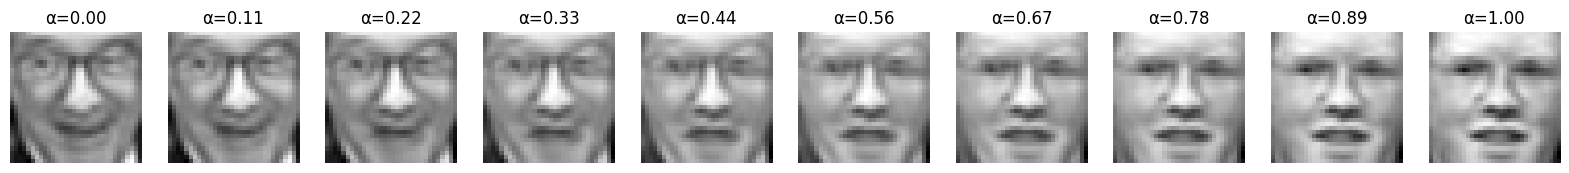

In [ ]:
def transition_faces(mean_Z, W_ml, scaler, start_idx, end_idx, num_steps=10):
    start_z = mean_Z[:, start_idx]
    end_z = mean_Z[:, end_idx]

    alphas = np.linspace(0, 1, num_steps)
    transitions = []

    for alpha in alphas:
        interpolated_z = (1 - alpha) * start_z + alpha * end_z
        x_interpolated = W_ml.dot(interpolated_z)
        x_reconstructed = scaler.inverse_transform(x_interpolated.reshape(1, -1))
        transitions.append(x_reconstructed.reshape(32, 32))

    plt.figure(figsize=(20, 4))
    for i, face in enumerate(transitions):
        plt.subplot(2, num_steps, i + 1)
        plt.imshow(face.T, cmap="gray")
        plt.axis("off")
        plt.title(f"α={alphas[i]:.2f}")
    plt.show()

    return transitions


start_face = 0  # índice de la cara inicial
end_face = 2  # índice de la cara final
transitions = transition_faces(mean_Z, W_ml, scaler, start_face, end_face, num_steps=10)